# NoteBook to Make Descriptives

This notebook is for looking at final population zonal stats data

In [83]:
from rasterstats import zonal_stats
import rasterio
import geopandas as gpd
import operator
import numpy as np
import pandas as pd
import matplotlib 
import seaborn as sns

# Functions

In [65]:
def city_search(gpd_df, city_list, country):
    """ function will print out city name and population for a subset of a gridded dataset gpd
    requires data frame, list of cities, and country of interest
    """
    gpd_df_sub = gpd_df[gpd_df['country'] == country]
    
    for index, row in gpd_df_sub.iterrows():
        for city in city_list:
            if row['city'] == city:
                print(city)
                print(round(row['PopTot']))

# Data

In [2]:
# File paths

data_raw = '/Users/cascade/Github/NTL/data/raw/'
data_temp = '/Users/cascade/Github/NTL/temp_data/'
data_interim = '/Users/cascade/Github/NTL/data/interim/'
ms_data = '/Users/cascade/Github/NTL/temp_data/MS_Data/'
erl_data = '/Users/cascade/Github/NTL/temp_data/ERL_data/'
downloads = '/Users/cascade/Downloads/'

In [68]:
# Data

GHS2000 = gpd.read_file(erl_data+'GHS_POP_GPW42000_final20190122.shp')
GHS2015 = gpd.rdatasets = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]ead_file(erl_data+'GHS_POP_GPW42015_final20190122.shp')
WP2000 = gpd.read_file(erl_data+'AFR_PPP_2000_adj_v2_final20190122.shp')
WP2015 = gpd.read_file(erl_data+'AFR_PPP_2015_adj_v2_final20190122.shp')
LS2015 = gpd.read_file(erl_data+'WPE_1KM_2016_final20190122.shp')
WPE2016 = gpd.read_file(erl_data+'LS15_final20190122.shp')

In [69]:
datasets = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

# Analysis

In [76]:
# Add dataset column to each dataset
# WPE2016['dataset'] = 'WPE2016'

In [77]:
WPE2016.head(1)

,osm_id,FID,country,city,osm_type,lat,lon,PopTot,aez_class,geometry,dataset
0,89369215,14962,Algeria,Tamanrasset,town,22.785454,5.532446,101883.0,Tropic - cool / arid,"POLYGON ((5.516667 22.816667, 5.533333 22.8166...",WPE2016


In [93]:
urban_concat = pd.concat([GHS2015, GHS2000,  WP2015, WP2000])


[None]

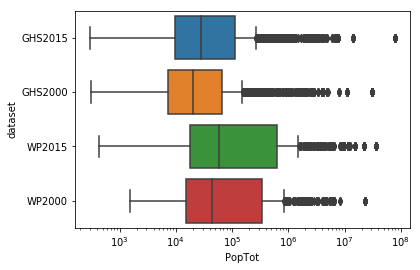

In [95]:
ax = sns.boxplot(x = 'PopTot', y = 'dataset', data = urban_concat)
ax.set(xscale="log")

[None]

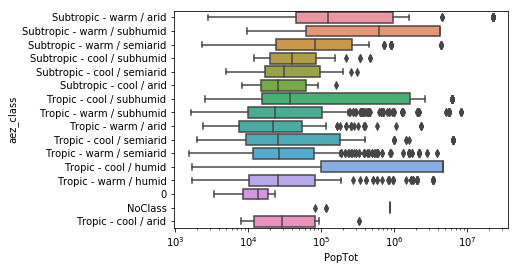

In [100]:
ax = sns.boxplot(x = 'PopTot', y = 'aez_class', data = WP2000)
ax.set(xscale="log")

[None]

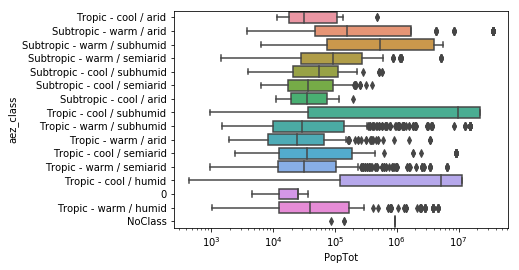

In [101]:
ax = sns.boxplot(x = 'PopTot', y = 'aez_class', data = WP2015)
ax.set(xscale="log")

In [111]:
WP2015_drop = WP2015.drop_duplicates('FID', keep=False)
WPE2016_drop = WPE2016.drop_duplicates('FID', keep=False)
print(WP2015.shape)
print(WPE2016.shape)
print(WP2015_drop.shape)
print(WPE2016_drop.shape)

(3854, 11)
(5552, 11)
(2291, 11)
(3959, 11)


In [129]:
result = pd.merge(WP2000[['osm_id', 'PopTot']], GHS2000[['osm_id', 'PopTot']], on='osm_id', how = 'inner')
print(WP2015.shape)
print(WPE2016.shape)
print(result.shape)


(3854, 11)
(5552, 11)
(1034765, 3)


In [122]:
result = result[result['country']=='Chad']

In [126]:
GHS2000.dtypes

osm_id         int64
FID            int64
country       object
city          object
osm_type      object
lat          float64
lon          float64
PopTot       float64
aez_class     object
geometry      object
dataset       object
dtype: object

In [130]:
raw_data = {
        'subject_id': ['1', '2', '3', '4', '5'],
        'first_name': ['Alex', 'Amy', 'Allen', 'Alice', 'Ayoung'], 
        'last_name': ['Anderson', 'Ackerman', 'Ali', 'Aoni', 'Atiches']}
df_a = pd.DataFrame(raw_data, columns = ['subject_id', 'first_name', 'last_name'])
df_a

,subject_id,first_name,last_name
0,1,Alex,Anderson
1,2,Amy,Ackerman
2,3,Allen,Ali
3,4,Alice,Aoni
4,5,Ayoung,Atiches


In [131]:
raw_data = {
        'subject_id': ['4', '5', '6', '7', '8'],
        'first_name': ['Billy', 'Brian', 'Bran', 'Bryce', 'Betty'], 
        'last_name': ['Bonder', 'Black', 'Balwner', 'Brice', 'Btisan']}
df_b = pd.DataFrame(raw_data, columns = ['subject_id', 'first_name', 'last_name'])
df_b

,subject_id,first_name,last_name
0,4,Billy,Bonder
1,5,Brian,Black
2,6,Bran,Balwner
3,7,Bryce,Brice
4,8,Betty,Btisan


In [132]:
raw_data = {
        'subject_id': ['1', '2', '3', '4', '5', '7', '8', '9', '10', '11'],
        'test_id': [51, 15, 15, 61, 16, 14, 15, 1, 61, 16]}
df_n = pd.DataFrame(raw_data, columns = ['subject_id','test_id'])
df_n

,subject_id,test_id
0,1,51
1,2,15
2,3,15
3,4,61
4,5,16
5,7,14
6,8,15
7,9,1
8,10,61
9,11,16


In [135]:
df_new = pd.concat([df_a, df_b])
df_new

,subject_id,first_name,last_name
0,1,Alex,Anderson
1,2,Amy,Ackerman
2,3,Allen,Ali
3,4,Alice,Aoni
4,5,Ayoung,Atiches
0,4,Billy,Bonder
1,5,Brian,Black
2,6,Bran,Balwner
3,7,Bryce,Brice
4,8,Betty,Btisan


In [136]:
pd.merge(df_new, df_n, on='subject_id')

,subject_id,first_name,last_name,test_id
0,1,Alex,Anderson,51
1,2,Amy,Ackerman,15
2,3,Allen,Ali,15
3,4,Alice,Aoni,61
4,4,Billy,Bonder,61
5,5,Ayoung,Atiches,16
6,5,Brian,Black,16
7,7,Bryce,Brice,14
8,8,Betty,Btisan,15


In [137]:
pd.merge(df_a, df_b, on='subject_id', how='inner')

,subject_id,first_name_x,last_name_x,first_name_y,last_name_y
0,4,Alice,Aoni,Billy,Bonder
1,5,Ayoung,Atiches,Brian,Black


In [210]:
df_test_a = WP2015[['osm_id', 'PopTot']]


df_test_b = GHS2015[['osm_id', 'PopTot']]
print(df_test_b.shape)
print(df_test_a.shape)

df_test_a_drop = df_test_a.drop_duplicates('osm_id', keep=False)
df_test_b_drop = df_test_b.drop_duplicates('osm_id', keep=False)
print(df_test_b_drop.shape)
print(df_test_a_drop.shape)

(6229, 2)
(3854, 2)
(4525, 2)
(2947, 2)


In [211]:
df_merge = pd.merge(df_test_a_drop, df_test_b_drop, on='osm_id', how='inner')

In [212]:
print(df_merge.shape)
df_merge.head()

(2703, 3)


,osm_id,PopTot_x,PopTot_y
0,89369215,3.170656e+04,9.709929e+04
1,252600742,5.632073e+06,6.772831e+06
2,253167052,5.632073e+06,6.772831e+06
3,253167208,5.632073e+06,6.772831e+06
4,253291208,6.839275e+04,5.279311e+04


Text(0,0.5,'GHS 2015')

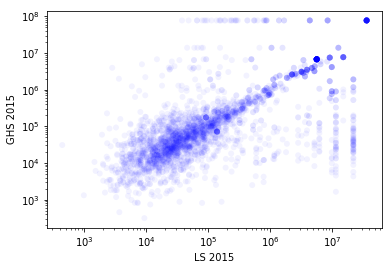

In [213]:
import matplotlib.pyplot as plt

#matplotlib.pyplot.scatter(df_merge['PopTot_x'], df_merge['PopTot_y'])

fig = plt.figure()
ax = plt.gca()
ax.scatter(df_merge['PopTot_x'] ,df_merge['PopTot_y'] , c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('LS 2015')
plt.ylabel('GHS 2015')

In [218]:
df_merge['dub'] = df_merge['PopTot_y']*df_merge['PopTot_x']
df_merge.head()

,osm_id,PopTot_x,PopTot_y,dub
0,89369215,3.170656e+04,9.709929e+04,3.078685e+09
1,252600742,5.632073e+06,6.772831e+06,3.814508e+13
2,253167052,5.632073e+06,6.772831e+06,3.814508e+13
3,253167208,5.632073e+06,6.772831e+06,3.814508e+13
4,253291208,6.839275e+04,5.279311e+04,3.610666e+09


In [219]:
df_merge_drop = df_merge.drop_duplicates('dub', keep=False)
print(df_merge_drop.shape)
print(df_merge.shape)

(1981, 4)
(2703, 4)


Text(0,0.5,'GHS 2015')

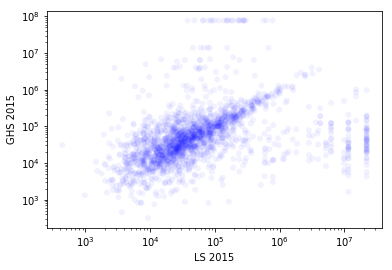

In [220]:
import matplotlib.pyplot as plt

#matplotlib.pyplot.scatter(df_merge['PopTot_x'], df_merge['PopTot_y'])

fig = plt.figure()
ax = plt.gca()
ax.scatter(df_merge_drop['PopTot_x'], df_merge_drop['PopTot_y'], c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('LS 2015')
plt.ylabel('GHS 2015')

In [221]:
from scipy import stats
x = df_merge_drop['PopTot_x']
y = df_merge_drop['PopTot_y']

stats.pearsonr(x, y) # return is (Pearson’s correlation coefficient, 2-tailed p-value)

(-0.02387470172875807, 0.2881875321684072)